# **GROUP PROJECT**


This group project is aimed to perform data ETL on PGMall's Electronic Accessories,
https://pgmall.my/index.php?route=product/category&path=592. <br> <br>

Group 17
Members :    
1. NUR FAZLINAH BINTI GULAM MOHAMED (A192414)
2. NURUL IMAN BINTI YUSUF (A192712)
3. NURUL SYAFIQA NAZIRAH (A179991)


# **1. DATA EXTRACTION**

In [80]:
# to install scrapy package
!pip install scrapy
!pip install fuzzywuzzy

1. **Import library**

In [81]:
#import the library
import scrapy
import scrapy.crawler as crawler
from multiprocessing import Process, Queue
from twisted.internet import reactor
import pandas as pd
import numpy as np


# helpful modules
import fuzzywuzzy
from fuzzywuzzy import process
import chardet

2. **Data Extraction with Spider**

In [82]:
products = []
# Create spider
class webSpider(scrapy.Spider):
  name = "content"
  start_urls=["https://pgmall.my/category?path=592&page=%d/" % i for i in range(0,20)]


  def parse(self, response):
    for content in response.css('div.product-pic.background-ffffff'):
      productLink=content.css("a::attr(href)").get()
      yield scrapy.Request(productLink, callback=self.parse_product)

  def parse_product(self, response):
    global products

    #select product
    detail=response.css('div.ix-PD-details')
    spec=response.css('div#product-spec-div')
    store = response.css("div#store-overview-div")

    #select attribute
    product = {
        "Product Name" : detail.css("span#prod_name::text").get(),
        "Brand" : spec.css('div#product-spec-Brand.col-md-8.col-xs-8.product-spec::text').get(),
        "Model" : spec.css('div#product-spec-Model::text').get(),
        "Price" : response.xpath('//meta[@property="product:price:amount"]/@content').get(),
        "Weight" : spec.xpath("//*[@id='product-spec-Weight(kg)']/text()").get(),
        "Product Dimension" : spec.xpath("//*[@id='product-spec-Dimension (Length x Width x Height)']/text()").get(),
        "Ship From" : spec.xpath('//div[@id="product-spec-Warranty Description"]/following-sibling::div[3]/text()').get(),
        "Manufacturing Country" :spec.xpath("//*[@id='product-spec-Manufacturing Country']/text()").get(),
        "Quantity" : response.css("span#product-qty::text").get(),
        "Rating" : detail.css("div.mini-rating-div > span ::text").get(),
        "Store Name" : store.css("span.store-name-new::text").get()
    }
    products.append(product)

  def closed(self,response):
     global df
     df = pd.DataFrame(products, columns=['Product Name',"Brand","Model","Price","Weight","Product Dimension","Ship From","Manufacturing Country","Quantity","Rating","Store Name"])
     df.to_csv('raw.csv', index = False)

In [83]:
# the wrapper to make it run your spider
def run_spider(spider):
    def f(q):
        try:
            runner = crawler.CrawlerRunner()
            deferred = runner.crawl(spider)
            deferred.addBoth(lambda _: reactor.stop())
            reactor.run()
            q.put(None)
        except Exception as e:
            q.put(e)

    q = Queue()
    p = Process(target=f, args=(q,))
    p.start()
    result = q.get()
    p.join()

    if result is not None:
        raise result

In [84]:
run_spider(webSpider)

/usr/local/lib/python3.10/dist-packages/scrapy/utils/request.py:254: ScrapyDeprecationWarning: '2.6' is a deprecated value for the 'REQUEST_FINGERPRINTER_IMPLEMENTATION' setting.

It is also the default value. In other words, it is normal to get this warning if you have not defined a value for the 'REQUEST_FINGERPRINTER_IMPLEMENTATION' setting. This is so for backward compatibility reasons, but it will change in a future version of Scrapy.

See the documentation of the 'REQUEST_FINGERPRINTER_IMPLEMENTATION' setting for information on how to handle this deprecation.
  return cls(crawler)


# **2. DATA TRANSFORMATION**

## **READ CSV**

In [85]:
filename = 'raw.csv'

In [86]:
headers = ['Product Name',"Brand","Model","Price","Weight","Product Dimension","Ship From","Manufacturing Country","Quantity","Rating","Store Name"]

In [87]:
df = pd.read_csv(filename, names = headers)
print("Done")

Done


In [88]:
df.drop(0, axis=0, inplace=True)

In [89]:
# To see what the data set looks like, we'll use the head() method.
df.head()

,Product Name,Brand,Model,Price,Weight,Product Dimension,Ship From,Manufacturing Country,Quantity,Rating,Store Name
1,EVO Pad - Washable and Reusable Super Sticky P...,: Not Specified,: Not Specified,8.00,: 0.02,: 8.00 x 8.00 x 0.50,: -,: Not Specified,95,No Rating Yet,EvoGadgets
2,EVO Pad - Washable and Reusable Super Sticky P...,: Not Specified,: Not Specified,8.00,: 0.02,: 8.00 x 8.00 x 0.50,: -,: Not Specified,181,No Rating Yet,EvoGadgets
3,"Car Holder rotate 360, mouse shape car holder,...",: Not Specified,: Not Specified,29.00,: 0.2,: 5.00 x 5.00 x 10.00,: Selangor,: Not Specified,22,4.4,cola520my
4,Spot gift K2 bluetooth microphone audio integr...,: No brand,": Microphone, stereo, home stereo, KTV singing,",118.00,: 1,: 22.00 x 15.00 x 12.00,: Free Trade Zone,: China,399,No Rating Yet,RUI YAO Grocery Store
5,Wireless Bluetooth Card Audio T-2096A Bluetoot...,: No brand,": Microphone, stereo, home stereo, KTV singing,",110.00,: 1,: 22.00 x 15.00 x 12.00,: Free Trade Zone,: China,399,No Rating Yet,RUI YAO Grocery Store


## **REMOVE INVALID CHARACTER FROM DATA**

In [90]:
df["Brand"]=df["Brand"].str.replace(": ","")
df['Brand'] = df['Brand'].str.strip()
df["Model"]=df["Model"].str.replace(": ","")
df["Product Dimension"]=df["Product Dimension"].str.replace(": ","")
df["Weight"]=df["Weight"].str.replace(": ","")
df['Quantity'] = df['Quantity'].str.strip()
df["Manufacturing Country"]=df["Manufacturing Country"].str.replace(": ","")
df["Ship From"]=df["Ship From"].str.replace(": ","")
df

,Product Name,Brand,Model,Price,Weight,Product Dimension,Ship From,Manufacturing Country,Quantity,Rating,Store Name
1,EVO Pad - Washable and Reusable Super Sticky P...,Not Specified,Not Specified,8.00,0.02,8.00 x 8.00 x 0.50,-,Not Specified,95,No Rating Yet,EvoGadgets
2,EVO Pad - Washable and Reusable Super Sticky P...,Not Specified,Not Specified,8.00,0.02,8.00 x 8.00 x 0.50,-,Not Specified,181,No Rating Yet,EvoGadgets
3,"Car Holder rotate 360, mouse shape car holder,...",Not Specified,Not Specified,29.00,0.2,5.00 x 5.00 x 10.00,Selangor,Not Specified,22,4.4,cola520my
4,Spot gift K2 bluetooth microphone audio integr...,No brand,"Microphone, stereo, home stereo, KTV singing,",118.00,1,22.00 x 15.00 x 12.00,Free Trade Zone,China,399,No Rating Yet,RUI YAO Grocery Store
5,Wireless Bluetooth Card Audio T-2096A Bluetoot...,No brand,"Microphone, stereo, home stereo, KTV singing,",110.00,1,22.00 x 15.00 x 12.00,Free Trade Zone,China,399,No Rating Yet,RUI YAO Grocery Store
...,...,...,...,...,...,...,...,...,...,...,...
996,Wireless microphone one to two microphone rece...,No brand,"Microphone, stereo, home stereo, KTV singing,",258.00,1,22.00 x 15.00 x 12.00,Free Trade Zone,China,399,No Rating Yet,HTYHG
997,D90 home universal wireless microphone recharg...,No brand,"Microphone, stereo, home stereo, KTV singing,",370.00,1,22.00 x 15.00 x 12.00,Free Trade Zone,China,399,No Rating Yet,HTYHG
998,"Industry wireless microphone, home karaoke liv...",No brand,"Microphone, stereo, home stereo, KTV singing,",350.00,1,22.00 x 15.00 x 12.00,Free Trade Zone,China,399,No Rating Yet,HTYHG
999,Langsheng universal wireless microphone 2.4G i...,No brand,"Microphone, stereo, home stereo, KTV singing,",160.00,1,22.00 x 15.00 x 12.00,Free Trade Zone,China,399,No Rating Yet,HTYHG


## **DETECT INCONSISTENT DATA**

**<h3>Brand</h3>**

In [91]:
# get all the unique values in the 'Brand' column
brand = df['Brand'].unique()

# sort them alphabetically and then take a closer look
brand.sort()
brand

array(['ASUS', 'Armaggeddon', 'CORSAIR', 'Cooler Master', 'DJI', 'GP',
       'HP', 'IETS', 'JOYROOM', 'KINGSTON', 'LIAN LI', 'MAXELL', 'MCDODO',
       'MG', 'MICROSOFT WINDOWS', 'MITSUBISHI', 'MONTECH', 'Marvo',
       'NO BRAND', 'No Brand', 'No brand', 'NoBrand', 'Not Specified',
       'OEM', 'OPPO', 'Oem', 'POLAR', 'Redmi', 'SAMSUNG', 'Samsung',
       'Vinnfier', 'Xiaomi', 'ZOTAC'], dtype=object)

**Get the closest matches for "NoBrand"**

In [92]:
# get the top 10 closest matches to ": NoBrand"
matches = fuzzywuzzy.process.extract("NoBrand", brand, limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

# take a look at them
matches

[('NoBrand', 100),
 ('NO BRAND', 67),
 ('No Brand', 67),
 ('No brand', 67),
 ('CORSAIR', 43),
 ('KINGSTON', 40),
 ('POLAR', 33),
 ('Redmi', 33),
 ('ZOTAC', 33),
 ('MCDODO', 31)]

In [93]:
# function to replace rows in the provided column of the provided dataframe
# that match the provided string above the provided ratio with the provided string
def replace_matches_in_column(df, column, string_to_match, min_ratio = 50):
    # get a list of unique strings
    strings = df[column].unique()

    # get the top 10 closest matches to our input string
    matches = fuzzywuzzy.process.extract(string_to_match, strings,
                                         limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

    # only get matches with a ratio > 90
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]

    # get the rows of all the close matches in our dataframe
    rows_with_matches = df[column].isin(close_matches)

    # replace all rows with close matches with the input matches
    df.loc[rows_with_matches, column] = string_to_match

    # let us know the function's done
    print("All done!")

In [94]:
# use the function we just wrote to replace close matches to ": NoBrand" with ": NoBrand"
replace_matches_in_column(df, column='Brand', string_to_match="NoBrand")

All done!


In [95]:
# get all the unique values in the 'Brand' column
brand = df['Brand'].unique()

# sort them alphabetically and then take a closer look
brand.sort()
brand

array(['ASUS', 'Armaggeddon', 'CORSAIR', 'Cooler Master', 'DJI', 'GP',
       'HP', 'IETS', 'JOYROOM', 'KINGSTON', 'LIAN LI', 'MAXELL', 'MCDODO',
       'MG', 'MICROSOFT WINDOWS', 'MITSUBISHI', 'MONTECH', 'Marvo',
       'NoBrand', 'Not Specified', 'OEM', 'OPPO', 'Oem', 'POLAR', 'Redmi',
       'SAMSUNG', 'Samsung', 'Vinnfier', 'Xiaomi', 'ZOTAC'], dtype=object)

**Get the closest matches for "OEM"**

In [96]:
# get the top 10 closest matches to ": OEM"
matches = fuzzywuzzy.process.extract("OEM", brand, limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

# take a look at them
matches

[('OEM', 100),
 ('Oem', 100),
 ('Redmi', 50),
 ('Xiaomi', 44),
 ('JOYROOM', 40),
 ('MG', 40),
 ('MONTECH', 40),
 ('Cooler Master', 38),
 ('IETS', 29),
 ('OPPO', 29)]

In [97]:
# function to replace rows in the provided column of the provided dataframe
# that match the provided string above the provided ratio with the provided string
def replace_matches_in_column(df, column, string_to_match, min_ratio = 60):
    # get a list of unique strings
    strings = df[column].unique()

    # get the top 10 closest matches to our input string
    matches = fuzzywuzzy.process.extract(string_to_match, strings,
                                         limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

    # only get matches with a ratio > 90
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]

    # get the rows of all the close matches in our dataframe
    rows_with_matches = df[column].isin(close_matches)

    # replace all rows with close matches with the input matches
    df.loc[rows_with_matches, column] = string_to_match

    # let us know the function's done
    print("All done!")

In [98]:
# use the function we just wrote to replace close matches to "Oem" with "OEM"
replace_matches_in_column(df, column='Brand', string_to_match="OEM")

All done!


In [99]:
# get all the unique values in the 'Brand' column
brand = df['Brand'].unique()

# sort them alphabetically and then take a closer look
brand.sort()
brand

array(['ASUS', 'Armaggeddon', 'CORSAIR', 'Cooler Master', 'DJI', 'GP',
       'HP', 'IETS', 'JOYROOM', 'KINGSTON', 'LIAN LI', 'MAXELL', 'MCDODO',
       'MG', 'MICROSOFT WINDOWS', 'MITSUBISHI', 'MONTECH', 'Marvo',
       'NoBrand', 'Not Specified', 'OEM', 'OPPO', 'POLAR', 'Redmi',
       'SAMSUNG', 'Samsung', 'Vinnfier', 'Xiaomi', 'ZOTAC'], dtype=object)

**Get the closest matches for "SAMSUNG"**

In [100]:
# get the top 10 closest matches to ": SAMSUNG"
matches = fuzzywuzzy.process.extract("SAMSUNG", brand, limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

# take a look at them
matches

[('SAMSUNG', 100),
 ('Samsung', 100),
 ('ASUS', 55),
 ('MG', 44),
 ('MITSUBISHI', 35),
 ('Armaggeddon', 33),
 ('Xiaomi', 31),
 ('CORSAIR', 29),
 ('LIAN LI', 29),
 ('MONTECH', 29)]

In [101]:
# function to replace rows in the provided column of the provided dataframe
# that match the provided string above the provided ratio with the provided string
def replace_matches_in_column(df, column, string_to_match, min_ratio = 60):
    # get a list of unique strings
    strings = df[column].unique()

    # get the top 10 closest matches to our input string
    matches = fuzzywuzzy.process.extract(string_to_match, strings,
                                         limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

    # only get matches with a ratio > 90
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]

    # get the rows of all the close matches in our dataframe
    rows_with_matches = df[column].isin(close_matches)

    # replace all rows with close matches with the input matches
    df.loc[rows_with_matches, column] = string_to_match

    # let us know the function's done
    print("All done!")

In [102]:
# use the function we just wrote to replace close matches to "Samsung" with "SAMSUNG"
replace_matches_in_column(df, column='Brand', string_to_match="SAMSUNG")

All done!


In [103]:
# get all the unique values in the 'Brand' column
brand = df['Brand'].unique()

# sort them alphabetically and then take a closer look
brand.sort()
brand

array(['ASUS', 'Armaggeddon', 'CORSAIR', 'Cooler Master', 'DJI', 'GP',
       'HP', 'IETS', 'JOYROOM', 'KINGSTON', 'LIAN LI', 'MAXELL', 'MCDODO',
       'MG', 'MICROSOFT WINDOWS', 'MITSUBISHI', 'MONTECH', 'Marvo',
       'NoBrand', 'Not Specified', 'OEM', 'OPPO', 'POLAR', 'Redmi',
       'SAMSUNG', 'Vinnfier', 'Xiaomi', 'ZOTAC'], dtype=object)

**<h3>Ship From</h3>**

In [104]:
# get all the unique values in the 'Ship From' column
ship = df['Ship From'].unique()

# sort them alphabetically and then take a closer look
ship.sort()
ship

array(['-', 'Free Trade Zone', 'Johor', 'Kedah', 'Kelantan',
       'Kuala Lumpur', 'Melaka', 'Perak', 'Selangor'], dtype=object)

**<h3>Manufacturing Country</h3>**

In [105]:
# Check whether have inconsistent records for manufacturing country
countries = df['Manufacturing Country'].unique()


# Sort the counrtries
countries.sort()
countries

array(['China', 'Japan', 'Malaysia', 'Not Specified'], dtype=object)

**<h3>Rating</h3>**

In [106]:
# Check whether have inconsistent records for manufacturing country
rating = df['Rating'].unique()


# Sort the counrtries
rating.sort()
rating

array(['4.4', '5.0', 'No Rating Yet'], dtype=object)

**Replace "No Rating Yet" to "none"**

In [107]:
df["Rating"]=df["Rating"].str.replace("No Rating Yet","none")

In [108]:
# Check whether have inconsistent records for manufacturing country
rating = df['Rating'].unique()


# Sort the counrtries
rating.sort()
rating

array(['4.4', '5.0', 'none'], dtype=object)

**<h3>Store Name</h3>**

In [109]:
# Check whether have inconsistent records for store name
stores = df['Store Name'].unique()
stores.sort()
stores

array(['6665 SHOP', 'A1 Distribution', 'Armaggeddon.os', 'Asia My',
       'BOLT GIZMO SDN BHD', 'CGi-Store', 'Chubeestore',
       'DNS DISTRIBUTOR', 'E-Nation', 'EvoGadgets', 'Fahim Online Store',
       'HTYHG', 'IETS Official Store', 'ITSCOM', 'MALAYSIA MERCHANT',
       'MARRONCAM (LEOS COM TRADING SDN BHD)', 'MKR HARDWARE',
       'Monaliza Online', 'Panda Motions Technology Official Store',
       'RUI YAO Grocery Store', 'Ryuakira', 'TENG MOBILE',
       'THUNDER GADGET KLTS', 'Tgadget', 'Uniq Plus', 'cola520my',
       'creditriskmanagement.my@gmail.com', 'eDIYonline.com.my',
       'netstore'], dtype=object)

## **REPLACE MISSING DATA WITH NAN**



In [110]:
# replace missing data to NaN
df['Brand'].replace("Not Specified", np.nan, inplace = True)
df['Model'].replace("Not Specified", np.nan, inplace = True)
df['Weight'].replace("0", np.nan, inplace = True)
df['Product Dimension'].replace("1.00 x 1.00 x 1.00", np.nan, inplace = True)
df['Ship From'].replace("-", np.nan, inplace = True)
df['Manufacturing Country'].replace("Not Specified", np.nan, inplace = True)
df

,Product Name,Brand,Model,Price,Weight,Product Dimension,Ship From,Manufacturing Country,Quantity,Rating,Store Name
1,EVO Pad - Washable and Reusable Super Sticky P...,NaN,NaN,8.00,0.02,8.00 x 8.00 x 0.50,NaN,NaN,95,none,EvoGadgets
2,EVO Pad - Washable and Reusable Super Sticky P...,NaN,NaN,8.00,0.02,8.00 x 8.00 x 0.50,NaN,NaN,181,none,EvoGadgets
3,"Car Holder rotate 360, mouse shape car holder,...",NaN,NaN,29.00,0.2,5.00 x 5.00 x 10.00,Selangor,NaN,22,4.4,cola520my
4,Spot gift K2 bluetooth microphone audio integr...,NoBrand,"Microphone, stereo, home stereo, KTV singing,",118.00,1,22.00 x 15.00 x 12.00,Free Trade Zone,China,399,none,RUI YAO Grocery Store
5,Wireless Bluetooth Card Audio T-2096A Bluetoot...,NoBrand,"Microphone, stereo, home stereo, KTV singing,",110.00,1,22.00 x 15.00 x 12.00,Free Trade Zone,China,399,none,RUI YAO Grocery Store
...,...,...,...,...,...,...,...,...,...,...,...
996,Wireless microphone one to two microphone rece...,NoBrand,"Microphone, stereo, home stereo, KTV singing,",258.00,1,22.00 x 15.00 x 12.00,Free Trade Zone,China,399,none,HTYHG
997,D90 home universal wireless microphone recharg...,NoBrand,"Microphone, stereo, home stereo, KTV singing,",370.00,1,22.00 x 15.00 x 12.00,Free Trade Zone,China,399,none,HTYHG
998,"Industry wireless microphone, home karaoke liv...",NoBrand,"Microphone, stereo, home stereo, KTV singing,",350.00,1,22.00 x 15.00 x 12.00,Free Trade Zone,China,399,none,HTYHG
999,Langsheng universal wireless microphone 2.4G i...,NoBrand,"Microphone, stereo, home stereo, KTV singing,",160.00,1,22.00 x 15.00 x 12.00,Free Trade Zone,China,399,none,HTYHG


## **CALCULATE MISSING DATA**

In [111]:
missing_data = df.isnull()
missing_data.head(5)
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("")

Product Name
False    1000
Name: Product Name, dtype: int64

Brand
False    940
True      60
Name: Brand, dtype: int64

Model
False    936
True      64
Name: Model, dtype: int64

Price
False    1000
Name: Price, dtype: int64

Weight
False    995
True       5
Name: Weight, dtype: int64

Product Dimension
False    965
True      35
Name: Product Dimension, dtype: int64

Ship From
False    996
True       4
Name: Ship From, dtype: int64

Manufacturing Country
False    909
True      91
Name: Manufacturing Country, dtype: int64

Quantity
False    1000
Name: Quantity, dtype: int64

Rating
False    1000
Name: Rating, dtype: int64

Store Name
False    1000
Name: Store Name, dtype: int64



## **REPLACE MISSING VALUE OF WEIGHT WITH MEAN**

In [112]:
avg_weight = df["Weight"].astype("float").mean(axis = 0)
df["Weight"].replace(np.nan, avg_weight, inplace = True)
missing_data = df.isnull()
missing_data.head(5)

for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("")

Product Name
False    1000
Name: Product Name, dtype: int64

Brand
False    940
True      60
Name: Brand, dtype: int64

Model
False    936
True      64
Name: Model, dtype: int64

Price
False    1000
Name: Price, dtype: int64

Weight
False    1000
Name: Weight, dtype: int64

Product Dimension
False    965
True      35
Name: Product Dimension, dtype: int64

Ship From
False    996
True       4
Name: Ship From, dtype: int64

Manufacturing Country
False    909
True      91
Name: Manufacturing Country, dtype: int64

Quantity
False    1000
Name: Quantity, dtype: int64

Rating
False    1000
Name: Rating, dtype: int64

Store Name
False    1000
Name: Store Name, dtype: int64



## **DROP ROW WITH MISSING DATA**

**<h3>PRODUCT DIMENSION, BRAND, MODEL, SHIP FROM, QUANTITY</h3>**

In [113]:
# Product Dimension
df.dropna(subset=["Product Dimension"], axis=0, inplace = True)
df.reset_index(drop = True, inplace = True)

# Brand
df.dropna(subset=["Brand"], axis=0, inplace = True)
df.reset_index(drop = True, inplace = True)

# Model
df.dropna(subset=["Model"], axis=0, inplace = True)
df.reset_index(drop = True, inplace = True)

# Ship From
df.dropna(subset=["Ship From"], axis=0, inplace = True)
df.reset_index(drop = True, inplace = True)

# Quantity
df.dropna(subset=["Quantity"], axis=0, inplace = True)
df.reset_index(drop = True, inplace = True)

# Manufacturing Country
df.dropna(subset=["Manufacturing Country"], axis=0, inplace = True)
df.reset_index(drop = True, inplace = True)

In [114]:
missing_data = df.isnull()

for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("")

Product Name
False    897
Name: Product Name, dtype: int64

Brand
False    897
Name: Brand, dtype: int64

Model
False    897
Name: Model, dtype: int64

Price
False    897
Name: Price, dtype: int64

Weight
False    897
Name: Weight, dtype: int64

Product Dimension
False    897
Name: Product Dimension, dtype: int64

Ship From
False    897
Name: Ship From, dtype: int64

Manufacturing Country
False    897
Name: Manufacturing Country, dtype: int64

Quantity
False    897
Name: Quantity, dtype: int64

Rating
False    897
Name: Rating, dtype: int64

Store Name
False    897
Name: Store Name, dtype: int64



**<h3>DIMENSION</h3>**

**EXTRACT LENGTH, WIDTH, HEIGHT FROM PRODUCT DIMENSION COLUMN**

In [115]:
df["Length"]=df["Product Dimension"].str.split(' x ').str[0]
df["Width"]=df["Product Dimension"].str.split(' x ').str[1]
df["Height"]=df["Product Dimension"].str.split(' x ').str[2]
df.head(10)

,Product Name,Brand,Model,Price,Weight,Product Dimension,Ship From,Manufacturing Country,Quantity,Rating,Store Name,Length,Width,Height
0,Spot gift K2 bluetooth microphone audio integr...,NoBrand,"Microphone, stereo, home stereo, KTV singing,",118.00,1,22.00 x 15.00 x 12.00,Free Trade Zone,China,399,none,RUI YAO Grocery Store,22.00,15.00,12.00
1,Wireless Bluetooth Card Audio T-2096A Bluetoot...,NoBrand,"Microphone, stereo, home stereo, KTV singing,",110.00,1,22.00 x 15.00 x 12.00,Free Trade Zone,China,399,none,RUI YAO Grocery Store,22.00,15.00,12.00
2,Ksong sound system with flashing lights and di...,NoBrand,"Microphone, stereo, home stereo, KTV singing,",216.00,1,22.00 x 15.00 x 12.00,Free Trade Zone,China,399,none,RUI YAO Grocery Store,22.00,15.00,12.00
3,New DY29S Night Light Clock Wireless Bluetooth...,NoBrand,"Microphone, stereo, home stereo, KTV singing,",220.00,1,22.00 x 15.00 x 12.00,Free Trade Zone,China,399,none,RUI YAO Grocery Store,22.00,15.00,12.00
4,Enping Langsheng microphone wireless transmitt...,NoBrand,"Microphone, stereo, home stereo, KTV singing,",300.00,1,22.00 x 15.00 x 12.00,Free Trade Zone,China,399,none,RUI YAO Grocery Store,22.00,15.00,12.00
5,New home karaoke singing microphone audio micr...,NoBrand,"Microphone, stereo, home stereo, KTV singing,",102.00,1,22.00 x 15.00 x 12.00,Free Trade Zone,China,399,none,RUI YAO Grocery Store,22.00,15.00,12.00
6,Space capsule cute pet Bluetooth speaker wirel...,NoBrand,"Microphone, stereo, home stereo, KTV singing,",96.00,1,22.00 x 15.00 x 12.00,Free Trade Zone,China,399,none,RUI YAO Grocery Store,22.00,15.00,12.00
7,"New outdoor bluetooth speaker, wireless portab...",NoBrand,"Microphone, stereo, home stereo, KTV singing,",72.00,1,22.00 x 15.00 x 12.00,Free Trade Zone,China,399,none,RUI YAO Grocery Store,22.00,15.00,12.00
8,Bluetooth wireless retro turntable sound creat...,NoBrand,"Microphone, stereo, home stereo, KTV singing,",158.00,1,22.00 x 15.00 x 12.00,Free Trade Zone,China,399,none,HTYHG,22.00,15.00,12.00
9,P6 new wireless Bluetooth speaker subwoofer cr...,NoBrand,"Microphone, stereo, home stereo, KTV singing,",132.00,1,22.00 x 15.00 x 12.00,Free Trade Zone,China,399,none,HTYHG,22.00,15.00,12.00


**GENERATE VOLUME FROM LENGTH, WIDTH, WEIGHT**

In [116]:
df["Volume"]=df["Length"].astype("float")*df["Width"].astype("float")*df["Height"].astype("float")
df

,Product Name,Brand,Model,Price,Weight,Product Dimension,Ship From,Manufacturing Country,Quantity,Rating,Store Name,Length,Width,Height,Volume
0,Spot gift K2 bluetooth microphone audio integr...,NoBrand,"Microphone, stereo, home stereo, KTV singing,",118.00,1,22.00 x 15.00 x 12.00,Free Trade Zone,China,399,none,RUI YAO Grocery Store,22.00,15.00,12.00,3960.0
1,Wireless Bluetooth Card Audio T-2096A Bluetoot...,NoBrand,"Microphone, stereo, home stereo, KTV singing,",110.00,1,22.00 x 15.00 x 12.00,Free Trade Zone,China,399,none,RUI YAO Grocery Store,22.00,15.00,12.00,3960.0
2,Ksong sound system with flashing lights and di...,NoBrand,"Microphone, stereo, home stereo, KTV singing,",216.00,1,22.00 x 15.00 x 12.00,Free Trade Zone,China,399,none,RUI YAO Grocery Store,22.00,15.00,12.00,3960.0
3,New DY29S Night Light Clock Wireless Bluetooth...,NoBrand,"Microphone, stereo, home stereo, KTV singing,",220.00,1,22.00 x 15.00 x 12.00,Free Trade Zone,China,399,none,RUI YAO Grocery Store,22.00,15.00,12.00,3960.0
4,Enping Langsheng microphone wireless transmitt...,NoBrand,"Microphone, stereo, home stereo, KTV singing,",300.00,1,22.00 x 15.00 x 12.00,Free Trade Zone,China,399,none,RUI YAO Grocery Store,22.00,15.00,12.00,3960.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
892,Wireless microphone one to two microphone rece...,NoBrand,"Microphone, stereo, home stereo, KTV singing,",258.00,1,22.00 x 15.00 x 12.00,Free Trade Zone,China,399,none,HTYHG,22.00,15.00,12.00,3960.0
893,D90 home universal wireless microphone recharg...,NoBrand,"Microphone, stereo, home stereo, KTV singing,",370.00,1,22.00 x 15.00 x 12.00,Free Trade Zone,China,399,none,HTYHG,22.00,15.00,12.00,3960.0
894,"Industry wireless microphone, home karaoke liv...",NoBrand,"Microphone, stereo, home stereo, KTV singing,",350.00,1,22.00 x 15.00 x 12.00,Free Trade Zone,China,399,none,HTYHG,22.00,15.00,12.00,3960.0
895,Langsheng universal wireless microphone 2.4G i...,NoBrand,"Microphone, stereo, home stereo, KTV singing,",160.00,1,22.00 x 15.00 x 12.00,Free Trade Zone,China,399,none,HTYHG,22.00,15.00,12.00,3960.0


**CHECK EXISTENCE OF MISSING VALUE**

In [117]:
missing_data = df.isnull()
missing_data.head(5)
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("")

Product Name
False    897
Name: Product Name, dtype: int64

Brand
False    897
Name: Brand, dtype: int64

Model
False    897
Name: Model, dtype: int64

Price
False    897
Name: Price, dtype: int64

Weight
False    897
Name: Weight, dtype: int64

Product Dimension
False    897
Name: Product Dimension, dtype: int64

Ship From
False    897
Name: Ship From, dtype: int64

Manufacturing Country
False    897
Name: Manufacturing Country, dtype: int64

Quantity
False    897
Name: Quantity, dtype: int64

Rating
False    897
Name: Rating, dtype: int64

Store Name
False    897
Name: Store Name, dtype: int64

Length
False    897
Name: Length, dtype: int64

Width
False    897
Name: Width, dtype: int64

Height
False    897
Name: Height, dtype: int64

Volume
False    897
Name: Volume, dtype: int64



**DROP PRODUCT DIMENSION, LENGTH, WIDTH, HEIGHT COLUMN**

In [118]:
df.drop(columns=['Product Dimension', 'Length','Width','Height'], inplace=True)
df.head()

,Product Name,Brand,Model,Price,Weight,Ship From,Manufacturing Country,Quantity,Rating,Store Name,Volume
0,Spot gift K2 bluetooth microphone audio integr...,NoBrand,"Microphone, stereo, home stereo, KTV singing,",118.00,1,Free Trade Zone,China,399,none,RUI YAO Grocery Store,3960.0
1,Wireless Bluetooth Card Audio T-2096A Bluetoot...,NoBrand,"Microphone, stereo, home stereo, KTV singing,",110.00,1,Free Trade Zone,China,399,none,RUI YAO Grocery Store,3960.0
2,Ksong sound system with flashing lights and di...,NoBrand,"Microphone, stereo, home stereo, KTV singing,",216.00,1,Free Trade Zone,China,399,none,RUI YAO Grocery Store,3960.0
3,New DY29S Night Light Clock Wireless Bluetooth...,NoBrand,"Microphone, stereo, home stereo, KTV singing,",220.00,1,Free Trade Zone,China,399,none,RUI YAO Grocery Store,3960.0
4,Enping Langsheng microphone wireless transmitt...,NoBrand,"Microphone, stereo, home stereo, KTV singing,",300.00,1,Free Trade Zone,China,399,none,RUI YAO Grocery Store,3960.0


**Round up the weight columns to two decimals**

In [119]:
df['Weight'] = df['Weight'].astype("float").round(decimals = 2)
df['Volume'] = df['Volume'].astype("float").round(decimals = 2)

**Capitalize product name, brand, model, ship from, store name**

In [120]:
df["Product Name"]=df["Product Name"].str.upper()
df["Brand"]=df["Brand"].str.upper()
df["Model"]=df["Model"].str.upper()
df["Ship From"]=df["Ship From"].str.upper()
df["Store Name"]=df["Store Name"].str.upper()
df["Rating"]=df["Rating"].str.upper()
df["Manufacturing Country"]=df["Manufacturing Country"].str.upper()

df.head()

,Product Name,Brand,Model,Price,Weight,Ship From,Manufacturing Country,Quantity,Rating,Store Name,Volume
0,SPOT GIFT K2 BLUETOOTH MICROPHONE AUDIO INTEGR...,NOBRAND,"MICROPHONE, STEREO, HOME STEREO, KTV SINGING,",118.00,1.0,FREE TRADE ZONE,CHINA,399,NONE,RUI YAO GROCERY STORE,3960.0
1,WIRELESS BLUETOOTH CARD AUDIO T-2096A BLUETOOT...,NOBRAND,"MICROPHONE, STEREO, HOME STEREO, KTV SINGING,",110.00,1.0,FREE TRADE ZONE,CHINA,399,NONE,RUI YAO GROCERY STORE,3960.0
2,KSONG SOUND SYSTEM WITH FLASHING LIGHTS AND DI...,NOBRAND,"MICROPHONE, STEREO, HOME STEREO, KTV SINGING,",216.00,1.0,FREE TRADE ZONE,CHINA,399,NONE,RUI YAO GROCERY STORE,3960.0
3,NEW DY29S NIGHT LIGHT CLOCK WIRELESS BLUETOOTH...,NOBRAND,"MICROPHONE, STEREO, HOME STEREO, KTV SINGING,",220.00,1.0,FREE TRADE ZONE,CHINA,399,NONE,RUI YAO GROCERY STORE,3960.0
4,ENPING LANGSHENG MICROPHONE WIRELESS TRANSMITT...,NOBRAND,"MICROPHONE, STEREO, HOME STEREO, KTV SINGING,",300.00,1.0,FREE TRADE ZONE,CHINA,399,NONE,RUI YAO GROCERY STORE,3960.0


**<h2>Check datatype</h2>**

In [121]:
df.dtypes

Product Name              object
Brand                     object
Model                     object
Price                     object
Weight                   float64
Ship From                 object
Manufacturing Country     object
Quantity                  object
Rating                    object
Store Name                object
Volume                   float64
dtype: object

# **3. LOAD**

**Save the dataframe to csv file**

In [122]:
df.to_csv('clean_df.csv')

# **4. DATA VISUALIZATION**

**Import the library**

In [123]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import seaborn as sns

**Read cleaned dataset**

In [124]:
df = pd.read_csv("clean_df.csv")
df.drop(df.filter(regex="Unname"),axis=1, inplace=True)
df.head()

,Product Name,Brand,Model,Price,Weight,Ship From,Manufacturing Country,Quantity,Rating,Store Name,Volume
0,SPOT GIFT K2 BLUETOOTH MICROPHONE AUDIO INTEGR...,NOBRAND,"MICROPHONE, STEREO, HOME STEREO, KTV SINGING,",118.0,1.0,FREE TRADE ZONE,CHINA,399,NONE,RUI YAO GROCERY STORE,3960.0
1,WIRELESS BLUETOOTH CARD AUDIO T-2096A BLUETOOT...,NOBRAND,"MICROPHONE, STEREO, HOME STEREO, KTV SINGING,",110.0,1.0,FREE TRADE ZONE,CHINA,399,NONE,RUI YAO GROCERY STORE,3960.0
2,KSONG SOUND SYSTEM WITH FLASHING LIGHTS AND DI...,NOBRAND,"MICROPHONE, STEREO, HOME STEREO, KTV SINGING,",216.0,1.0,FREE TRADE ZONE,CHINA,399,NONE,RUI YAO GROCERY STORE,3960.0
3,NEW DY29S NIGHT LIGHT CLOCK WIRELESS BLUETOOTH...,NOBRAND,"MICROPHONE, STEREO, HOME STEREO, KTV SINGING,",220.0,1.0,FREE TRADE ZONE,CHINA,399,NONE,RUI YAO GROCERY STORE,3960.0
4,ENPING LANGSHENG MICROPHONE WIRELESS TRANSMITT...,NOBRAND,"MICROPHONE, STEREO, HOME STEREO, KTV SINGING,",300.0,1.0,FREE TRADE ZONE,CHINA,399,NONE,RUI YAO GROCERY STORE,3960.0


**Copy the data**

In [125]:
df_clean = pd.read_csv("clean_df.csv")
df_clean.drop(df_clean.filter(regex="Unname"), axis=1, inplace=True)
df_clean.head()

,Product Name,Brand,Model,Price,Weight,Ship From,Manufacturing Country,Quantity,Rating,Store Name,Volume
0,SPOT GIFT K2 BLUETOOTH MICROPHONE AUDIO INTEGR...,NOBRAND,"MICROPHONE, STEREO, HOME STEREO, KTV SINGING,",118.0,1.0,FREE TRADE ZONE,CHINA,399,NONE,RUI YAO GROCERY STORE,3960.0
1,WIRELESS BLUETOOTH CARD AUDIO T-2096A BLUETOOT...,NOBRAND,"MICROPHONE, STEREO, HOME STEREO, KTV SINGING,",110.0,1.0,FREE TRADE ZONE,CHINA,399,NONE,RUI YAO GROCERY STORE,3960.0
2,KSONG SOUND SYSTEM WITH FLASHING LIGHTS AND DI...,NOBRAND,"MICROPHONE, STEREO, HOME STEREO, KTV SINGING,",216.0,1.0,FREE TRADE ZONE,CHINA,399,NONE,RUI YAO GROCERY STORE,3960.0
3,NEW DY29S NIGHT LIGHT CLOCK WIRELESS BLUETOOTH...,NOBRAND,"MICROPHONE, STEREO, HOME STEREO, KTV SINGING,",220.0,1.0,FREE TRADE ZONE,CHINA,399,NONE,RUI YAO GROCERY STORE,3960.0
4,ENPING LANGSHENG MICROPHONE WIRELESS TRANSMITT...,NOBRAND,"MICROPHONE, STEREO, HOME STEREO, KTV SINGING,",300.0,1.0,FREE TRADE ZONE,CHINA,399,NONE,RUI YAO GROCERY STORE,3960.0


## **PRICE**



**<h3>Before Data Cleaning</h3>**

**Plot histogram for price column**



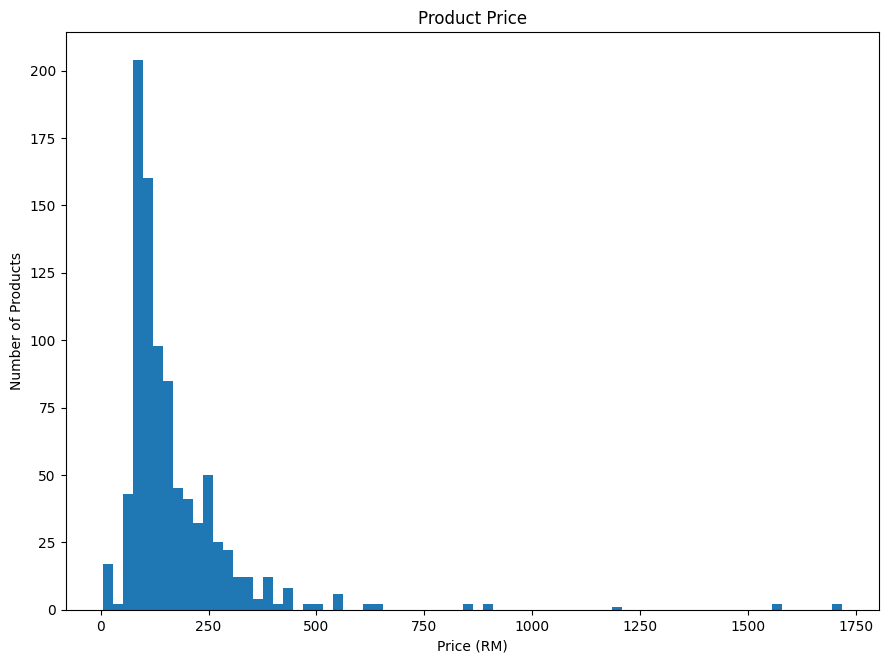

In [126]:
plt.figure().set_size_inches(10.5, 7.5)
plt.hist(df["Price"], bins="auto")

# Label
plt.title("Product Price")
plt.xlabel("Price (RM)")
plt.ylabel("Number of Products")

plt.show()

**Plot boxplot for price column**

<Figure size 640x480 with 0 Axes>

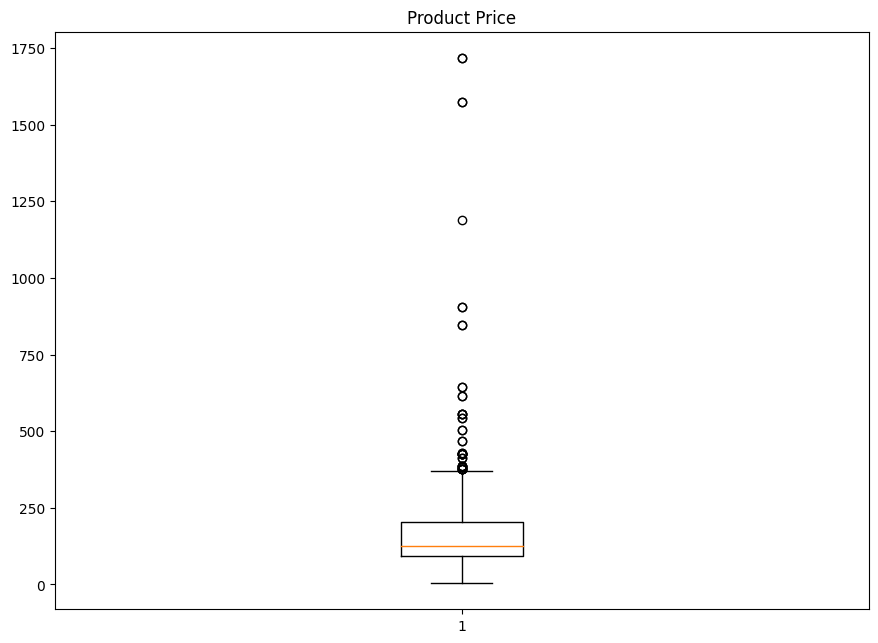

In [127]:
plt.figure()
plt.figure().set_size_inches(10.5, 7.5)
plt.boxplot(df["Price"])

# Label
plt.title("Product Price")


plt.show()

**<h3>After Data Cleaning</h3>**

In [128]:
# Calculate Data
Q1 = df_clean['Price'].quantile(0.25)
Q3 = df_clean['Price'].quantile(0.75)
IQR = Q3-Q1
lower_boundary = Q1- 1.5*IQR
upper_boundary = Q3+ 1.5*IQR
max = df_clean['Price'].max()
min = df_clean['Price'].min()

print("Q1: ", Q1)
print("Q3: ", Q3)
print("lower boundary: ", lower_boundary)
print("upper boundary: " , upper_boundary)
print("Maximum: ", max)
print("Minimum: ", min)

Q1:  92.0
Q3:  204.0
lower boundary:  -76.0
upper boundary:  372.0
Maximum:  1718.0
Minimum:  4.8


In [129]:
df_clean['Price'] = np.where(df_clean['Price']>upper_boundary,  upper_boundary, np.where(df_clean['Price']<lower_boundary, 1 , df_clean['Price']))

**Plot histogram for price column**

<Figure size 640x480 with 0 Axes>

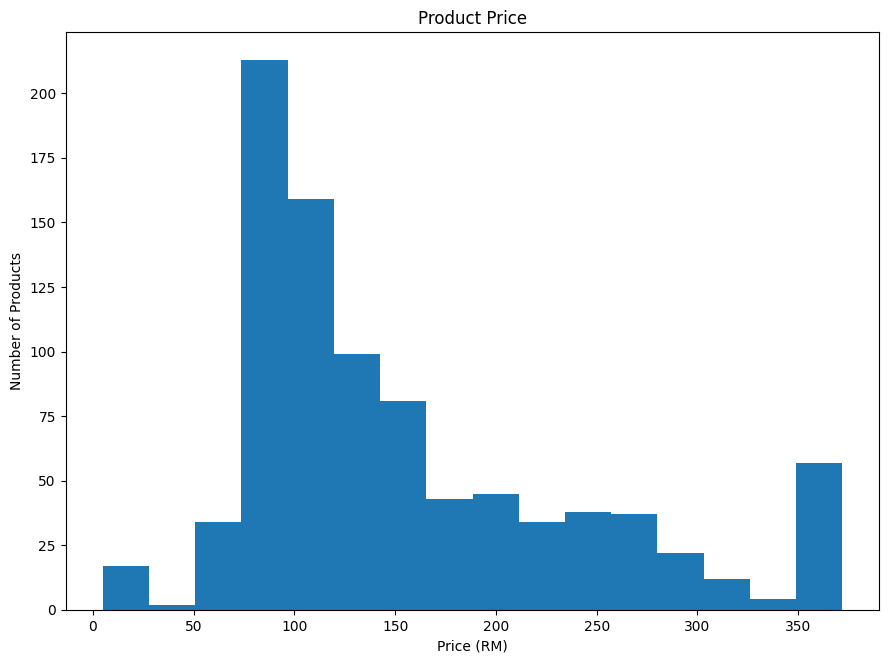

In [130]:
plt.figure()
plt.figure().set_size_inches(10.5, 7.5)
plt.hist(df_clean["Price"], bins="auto")

# Label
plt.title("Product Price")
plt.xlabel("Price (RM)")
plt.ylabel("Number of Products")

plt.show()

**Plot boxplot for price column**

<Figure size 640x480 with 0 Axes>

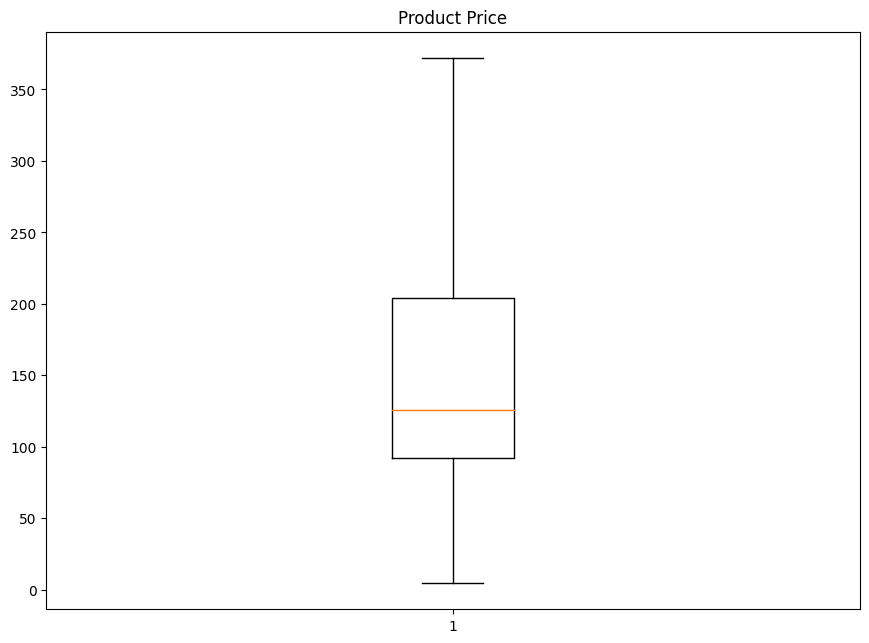

In [131]:
plt.figure()
plt.figure().set_size_inches(10.5, 7.5)
plt.boxplot(df_clean["Price"])

# Label
plt.title("Product Price")

plt.show()

## **QUANTITY**




**<h3>Before Data Cleaning</h3>**

**Plot histogram for quantity column**

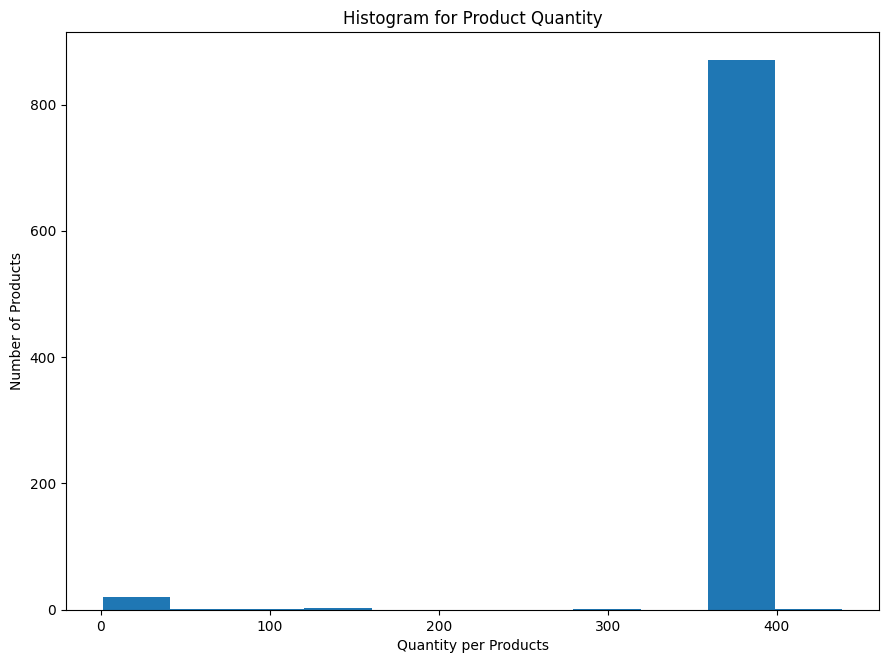

In [132]:
plt.figure().set_size_inches(10.5, 7.5)
plt.hist(df["Quantity"], bins="auto")

# Label
plt.title("Histogram for Product Quantity")
plt.xlabel("Quantity per Products")
plt.ylabel("Number of Products")

plt.show()

**Plot boxplot for quantity column**

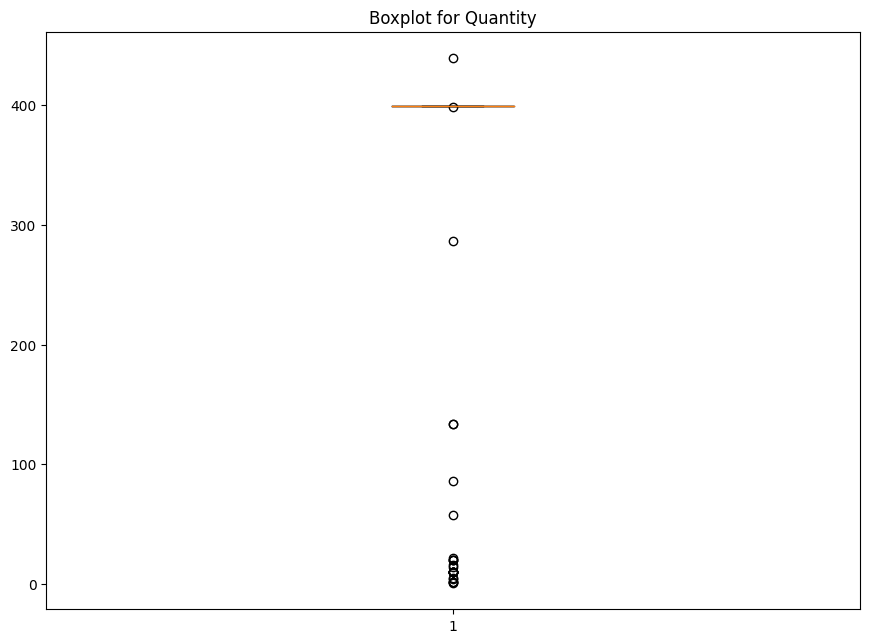

In [145]:
# Convert "Quantity" column to numeric
df["Quantity"] = pd.to_numeric(df["Quantity"], errors="coerce")  # "coerce" will replace non-numeric values with NaN

plt.figure().set_size_inches(10.5, 7.5)
plt.boxplot(df["Quantity"])

# Set the title
plt.title("Boxplot for Quantity")

plt.show()

**<h3>After Data Cleaning</h3>**

In [134]:
# Calculate Data
Q1 = df_clean['Quantity'].quantile(0.25)
Q3 = df_clean['Quantity'].quantile(0.75)
IQR = Q3-Q1
lower_boundary = Q1- 1.5*IQR
upper_boundary = Q3+ 1.5*IQR
max = df_clean['Quantity'].max()
min = df_clean['Quantity'].min()

print("Q1: ", Q1)
print("Q3: ", Q3)
print("lower boundary: ", lower_boundary)
print("upper boundary: " , upper_boundary)
print("Maximum: ", max)
print("Minimum: ", min)

Q1:  399.0
Q3:  399.0
lower boundary:  399.0
upper boundary:  399.0
Maximum:  439
Minimum:  1


In [135]:
df_clean['Quantity'] = np.where(df_clean['Quantity']>upper_boundary,  upper_boundary, np.where(df_clean['Quantity']<lower_boundary, 1 , df_clean['Quantity']))

**Plot histogram for quantity column**

<Figure size 640x480 with 0 Axes>

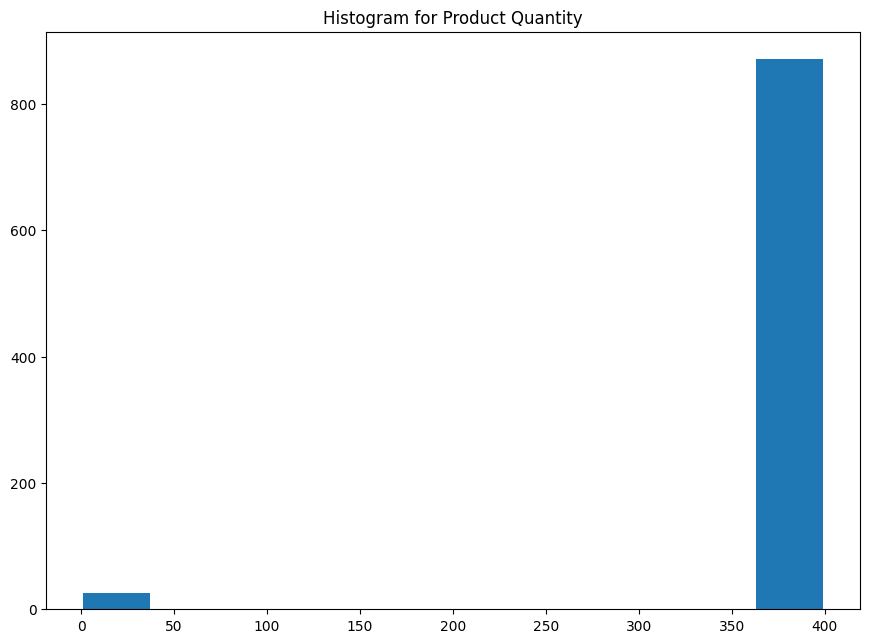

In [136]:
plt.figure()
plt.figure().set_size_inches(10.5, 7.5)
plt.hist(df_clean["Quantity"], bins="auto")

# Set the title
plt.title("Histogram for Product Quantity")

plt.show()

**Plot boxplot for quantity column**

<Figure size 640x480 with 0 Axes>

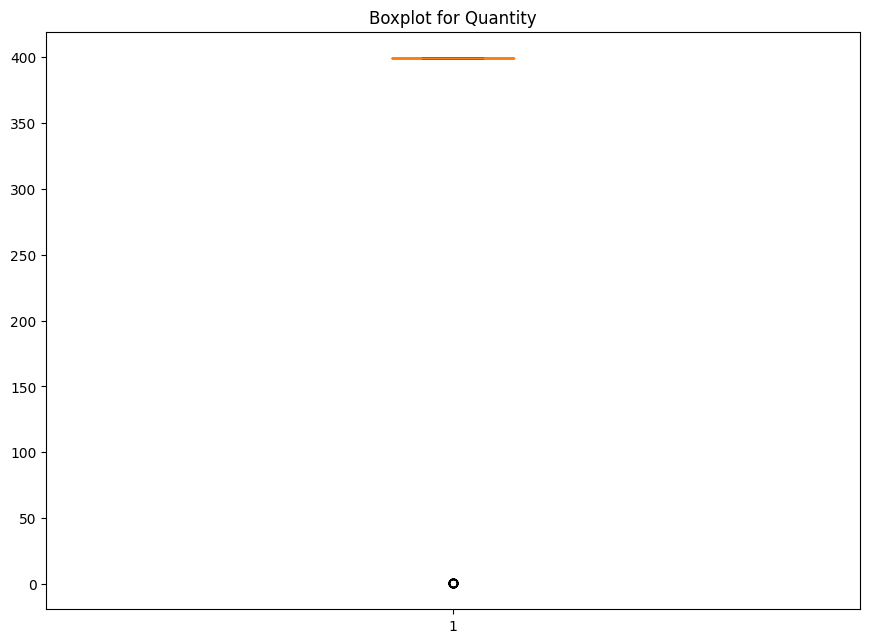

In [146]:
plt.figure()
plt.figure().set_size_inches(10.5, 7.5)
plt.boxplot(df_clean["Quantity"])

# Set the title
plt.title("Boxplot for Quantity")

# Show the plot
plt.show()

## **SCATTERPLOT FOR WEIGHT AND VOLUME**


**Plot scatterplot for weight and volume**

<Figure size 640x480 with 0 Axes>

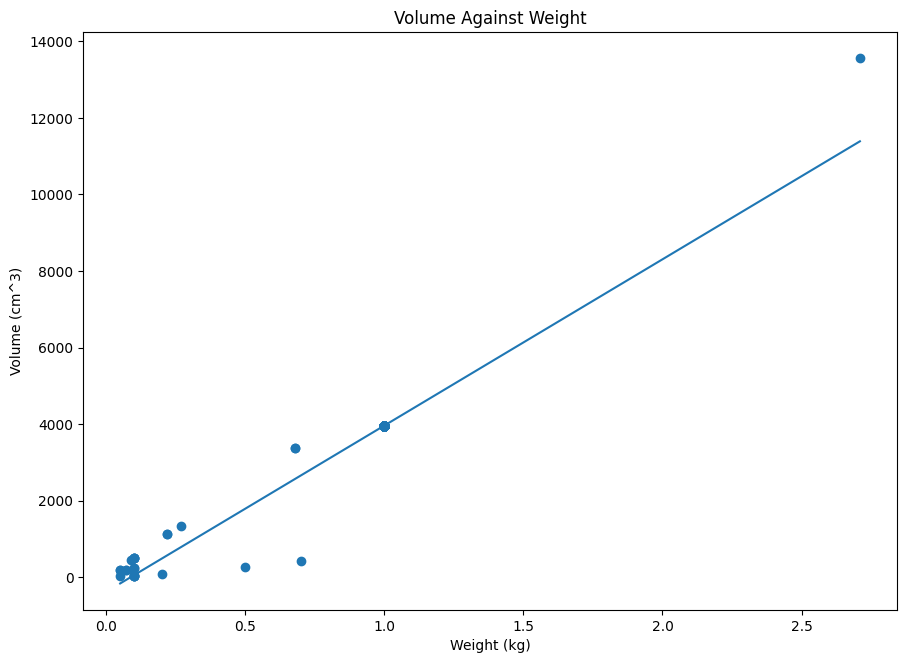

In [138]:
plt.figure()
plt.figure().set_size_inches(10.5, 7.5)
plt.scatter(df_clean["Weight"],df_clean["Volume"])
plt.xlabel('Weight (kg)')
plt.ylabel('Volume (cm^3)')

# Label
plt.title("Volume Against Weight")

#best fit line for the graph
plt.plot(np.unique(df_clean["Weight"]), np.poly1d(np.polyfit(df_clean["Weight"], df_clean["Volume"], 1))(np.unique(df_clean["Weight"])))
plt.show()

In [139]:
df_clean[["Weight","Volume"]].corr()

,Weight,Volume
Weight,1.000000,0.979153
Volume,0.979153,1.000000


In [140]:
print("Minimum Weight:",df_clean["Weight"].min())
print("Maximum Weight:",df_clean["Weight"].max())

Minimum Weight: 0.05
Maximum Weight: 2.71


## **CATEGORICAL PLOT FOR STORE NAME AND QUANTITY**

**Plot scatterplot for Store Name and Quantity**

**<h3>Before data cleaning</h3>**

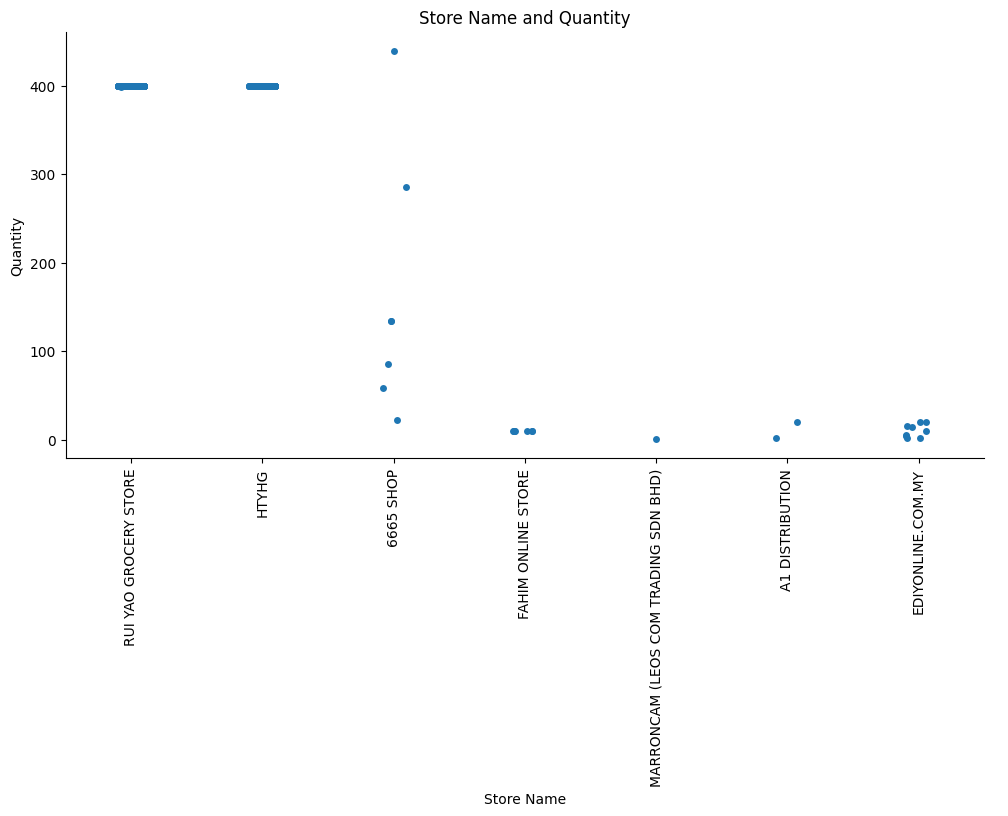

In [141]:
g = sns.catplot(x="Store Name", y="Quantity", data=df,height=5, aspect=2)
g.set_xticklabels(rotation = 90)

# Set the title
plt.title("Store Name and Quantity")

# Show the plot
plt.show()

**<h3>After data cleaning</h3>**

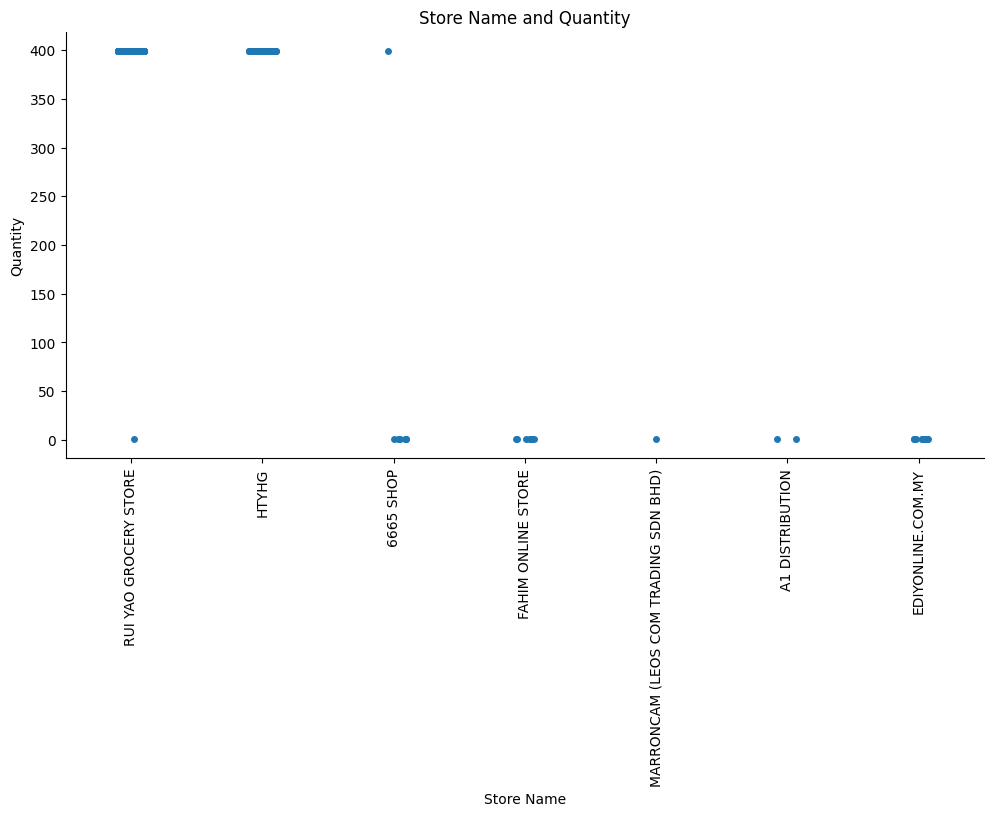

In [142]:
g = sns.catplot(x="Store Name", y="Quantity", data=df_clean,height=5, aspect=2)
g.set_xticklabels(rotation = 90)

# Set the title
plt.title("Store Name and Quantity")

# Show the plot
plt.show()

## **CATEGORICAL PLOT FOR BRAND AND PRICE**

**<h3>Before data cleaning</h3>**

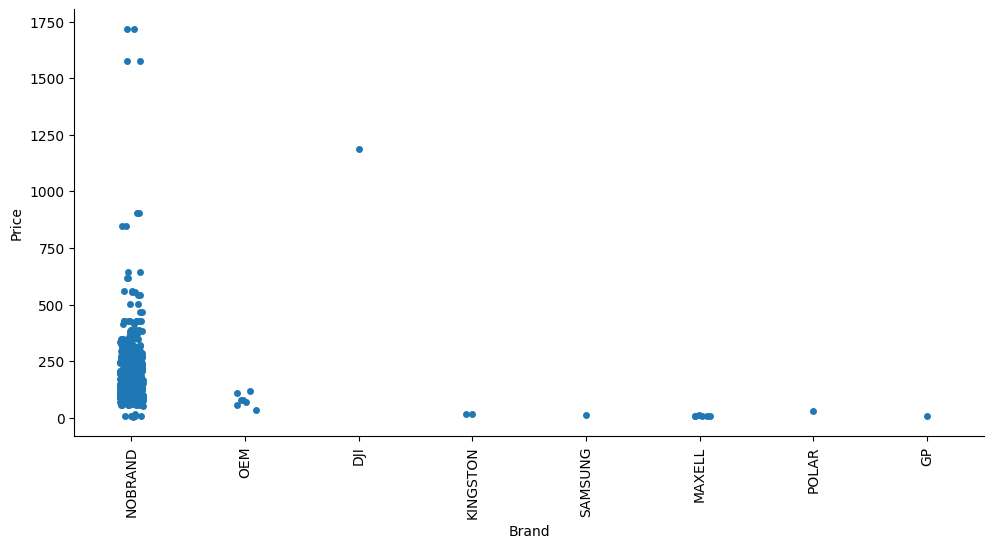

In [143]:
g = sns.catplot(x="Brand", y="Price", data=df,height=5, aspect=2)
g.set_xticklabels(rotation = 90)


**<h3>After data cleaning</h3>**

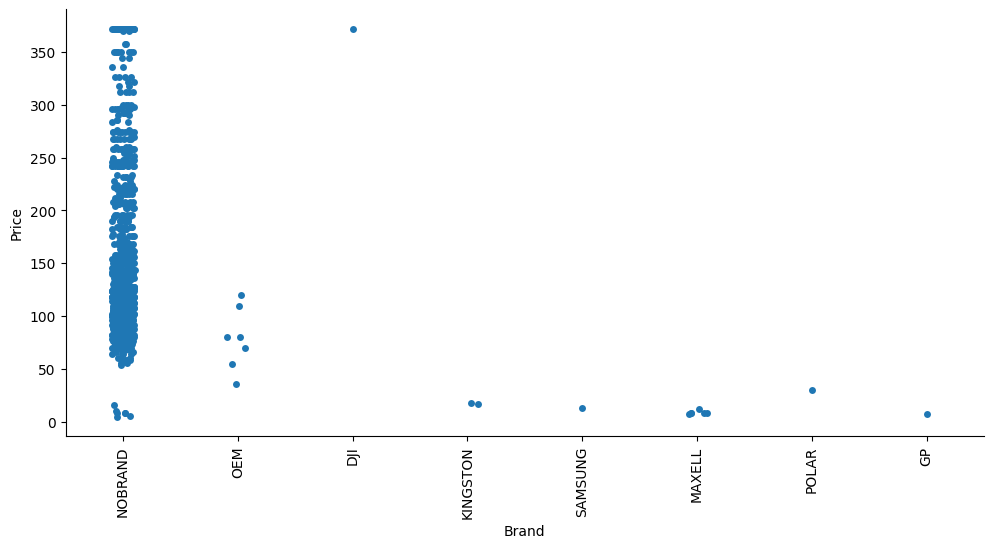

In [144]:
g = sns.catplot(x="Brand", y="Price", data=df_clean,height=5, aspect=2)
g.set_xticklabels(rotation = 90)

In [147]:
df_clean.to_csv('cleaned_df.csv')